# Autoencoder for matrix imputation

In some cases our data contains missing values. In this exercise we will implement an autoencoder to impute the missing values. 

<img src="ae_arch.png" width=600 height=400 />

As shown in the figure, the autoencoder receives as input the incomplete data and retrieves an imputed version after training.

The autoencoder is trained in a similar way as usual, but we need to masked the NaN values in the loss function 

$\mathcal{L} = \sum_{i,j: (i,j) \in S} (X_{ij} - \hat{X}_{ij})^{2}$. Notice that if your pixels are normalized between 0 and 1 you can also use binary cross entropy. 

The set $S$ are all the $(i,j)$ pairs with known entries.

Things to consider: 
- You have to mask some entries of the loss. Thus, you need to find the NaN entries and use their indices. Also make sure you use a loss that allows you to mask entries.
- The NaN values in your input matrix should be transformed to zeros since the layers in torch does not handle NaN entries. 

In [2]:
import numpy as np
import torchvision
from torchvision import transforms
import pandas as pd
import sklearn
import torch
import itertools
from PIL import Image, ImageFilter 

import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset
import seaborn as sns
import pandas as pd

from tensorflow.keras.datasets import mnist

2022-11-18 16:39:11.139316: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-18 16:39:11.379255: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-18 16:39:11.419991: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-18 16:39:11.420005: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [3]:
class MnistDigitsM():   
    def __init__(self, n_samples = 5000, perc_mask = 0.1):
        (train_images, Y_train), (test_images, Y_test) = mnist.load_data()
        train_images = train_images[:n_samples]
        inputs = train_images.reshape((n_samples, 784))/255.
        inputs = inputs[:n_samples]
        self.labels = Y_train[:n_samples]
        self.true_data = inputs.copy()
        inputs_flat = inputs.ravel()
        ind = np.arange(len(inputs_flat))
        ind_mask = np.random.choice(ind, int(ind.shape[0] * perc_mask))
        inputs_flat[ind_mask] = np.nan
        # mask perc_mask of data 
        self.data_train = inputs
        self.test_ind = np.where(np.isnan(inputs))

In [4]:
data = MnistDigitsM(perc_mask = 0.9)

In [5]:
data.data_train

array([[nan, nan, nan, ...,  0.,  0., nan],
       [ 0., nan, nan, ...,  0.,  0.,  0.],
       [nan, nan,  0., ..., nan, nan, nan],
       ...,
       [nan,  0.,  0., ...,  0.,  0., nan],
       [nan,  0., nan, ..., nan, nan,  0.],
       [nan,  0.,  0., ..., nan, nan, nan]])

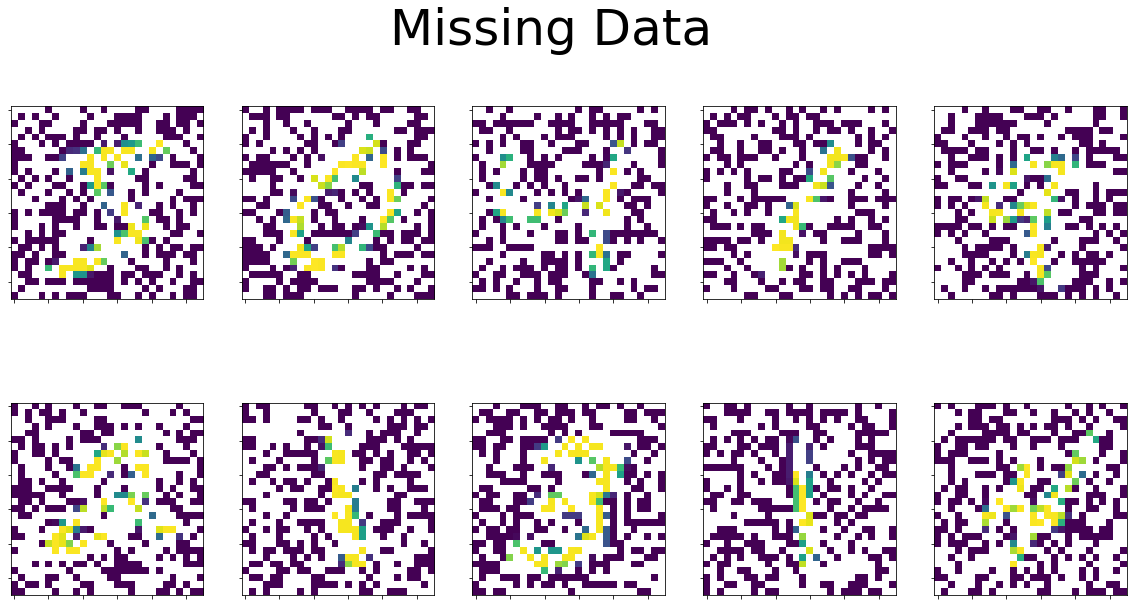

In [6]:
def plot_images(images, img_prow, width, length, title = None):
    '''
    Takes images as rows in numpy arrays
    img_prow is the number of images per row.
    '''
    rows = np.ceil(len(images)/img_prow).astype(int)
    fig, (a1) = plt.subplots(rows, img_prow, figsize=(20, 10))
    fig.suptitle(title, size = 50)
    images = images.reshape(len(images), width, length)      
    row_ind = 0
    col_ind = 0
    
    for k in range(len(images)):
        a1[row_ind, col_ind].imshow(images[k,:,:])
        a1[row_ind, col_ind].set_xticklabels([])
        a1[row_ind, col_ind].set_yticklabels([])
        col_ind += 1
        if col_ind > img_prow - 1:
            col_ind  = 0
            row_ind += 1 
    plt.show()
    
plot_images(data.data_train[:10], 5, 28, 28, title = "Missing Data")

### Sklearn methods 

Let's try some simple methods available in sklearn to compare with our final solution

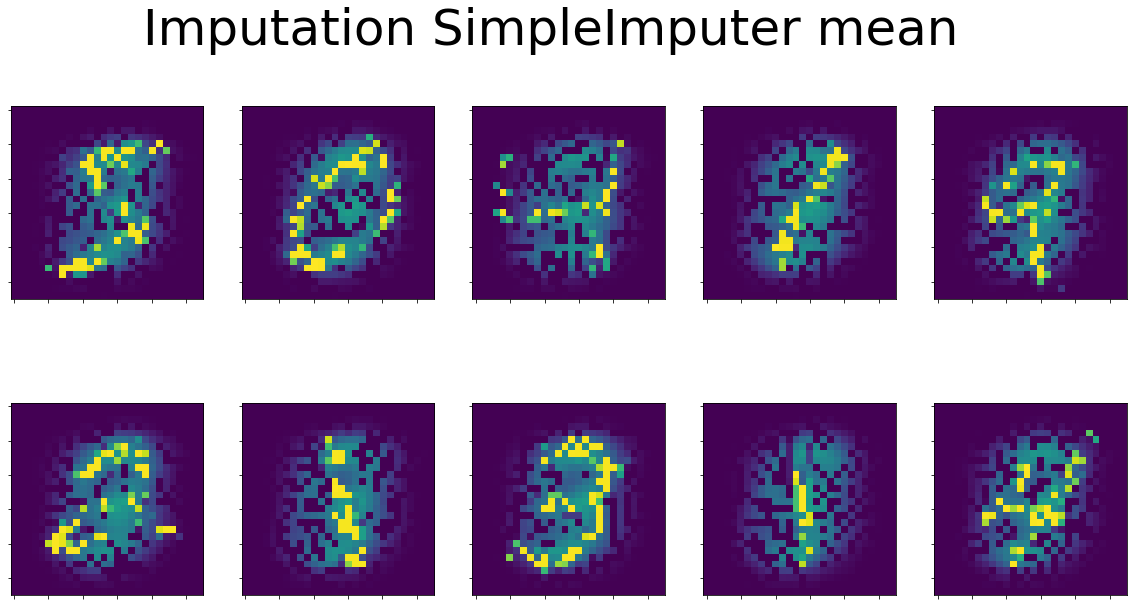

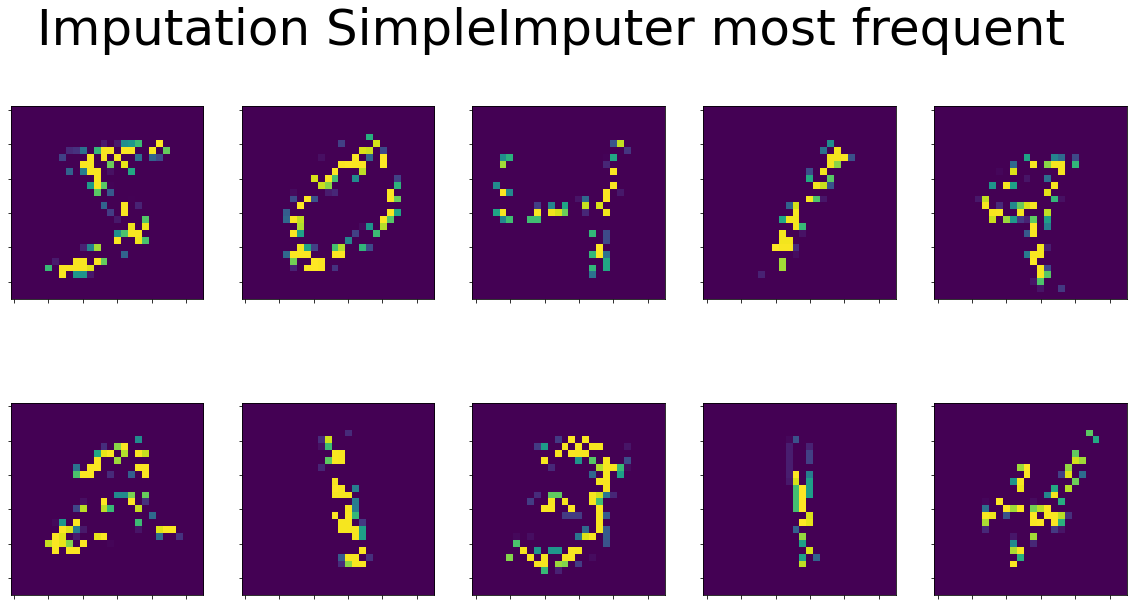

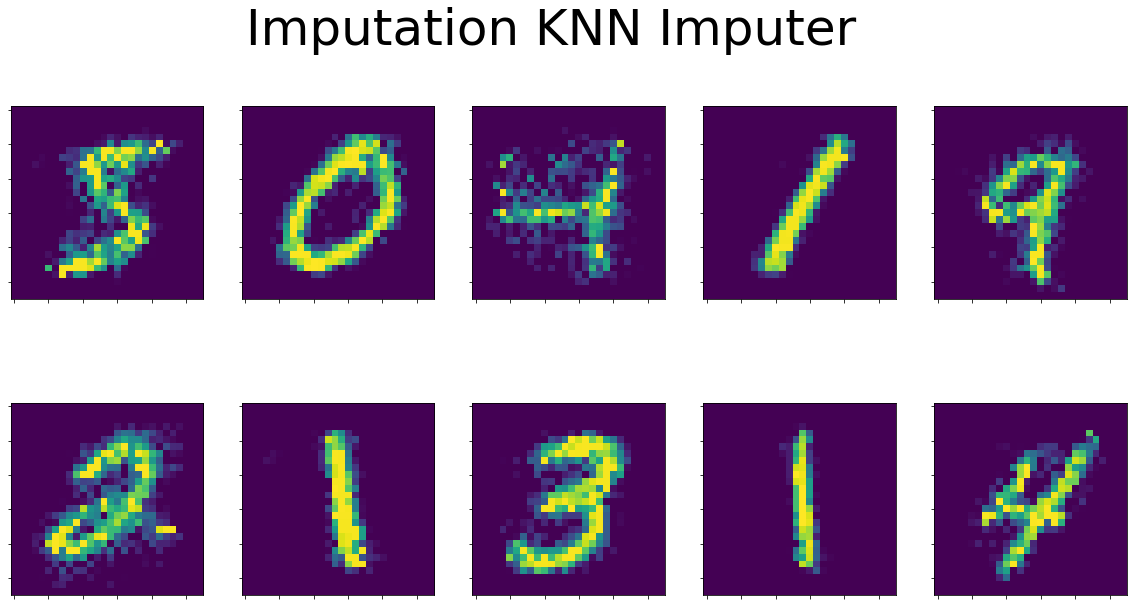

In [7]:
from sklearn.impute import SimpleImputer, KNNImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
rec = imp.fit_transform(data.data_train)
plot_images(rec[:10], 5, 28, 28, title = "Imputation SimpleImputer mean")

imp = SimpleImputer(missing_values = np.nan, strategy = "most_frequent")
rec = imp.fit_transform(data.data_train)
plot_images(rec[:10], 5, 28, 28, title = "Imputation SimpleImputer most frequent")


rec = KNNImputer(n_neighbors=10, weights="uniform").fit_transform(data.data_train)
plot_images(rec[:10], 5, 28, 28, title = "Imputation KNN Imputer")

In [8]:
class dataset(Dataset):
        def __init__(self, X, mask):
            self.X = X
            self.mask = mask
        def __len__(self):
            return len(self.X)   
        def __getitem__(self, idx):
            return self.X[idx], self.mask[idx]

### Create the model architecture: 
 - Your AE_module should be able to take any number of hidden layers 
 - You could use the nn.Sequential module of pytorch and get a module that looks as:

In [9]:
def pairs(iterable):
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)  


In [33]:
class AE_module(nn.Module):
    def __init__(self, input_dim, hidden_dims, z_dim):
        super().__init__()
        '''***Complete the init method and the forward pass***
        The input_dim is the number of features of your data
        hidden_dim is a list containing the inner layers dimensions as specified above
        z_dim is the dimension of the bottleneck 
        '''
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU(),   
        )
    
        for dim1, dim2 in pairs(hidden_dims):
            self.encoder.append(nn.Linear(dim1, dim2))
            self.encoder.append(nn.ReLU())

        self.encoder.append(nn.Linear(hidden_dims[-1], z_dim))


        self.decoder = nn.Sequential(nn.Linear(z_dim, hidden_dims[-1]))
        self.decoder.append(nn.ReLU())
        
        for dim1, dim2 in pairs(reversed(hidden_dims)):
            self.decoder.append(nn.Linear(dim1, dim2))
            self.decoder.append(nn.ReLU())

        self.decoder.append(nn.Linear(hidden_dims[0], input_dim))
        self.decoder.append(nn.Sigmoid())

    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        return out

In [48]:
class AE_MI():
    """Autoencoder for Matrix Imputation"""

    def __init__(self,  lr=1e-3, 
                 epochs=1000, 
                 batch_size=128, 
                 weight_decay=0,
                 hidden_dims=[300, 200, 100], 
                 z_size = 50):
        
        # The learning rate for the optimizer 
        self.lr = lr
        
        # number of epochs and batch size
        self.epochs = epochs
        self.batch_size = batch_size
        self.weight_decay = weight_decay
        
        # dimension of the hidden layers
        self.hidden_dims = hidden_dims  
        # dimension of the bottleneck 
        self.z_size  = z_size   

        '''***define the reconstruction criterion***'''
        self.criterion = nn.CrossEntropyLoss()

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def fit(self, X):
        

        X = torch.Tensor(X)
        
        # Find zero values to mask to compute the loss
        indices = torch.where(~torch.isnan(X))
        mask_m = torch.zeros(X.shape)
        mask_m[indices[0], indices[1]] = 1
        self.mask = mask_m
        X = torch.nan_to_num_(X)
        


        input_size = X.shape[1]
      
        # Call the AE_module implemented above 
        self.torch_module = AE_module(input_dim=input_size,
                                    hidden_dims=self.hidden_dims,
                                    z_dim=self.z_size)
            
        # define optimizer
        self.optimizer = torch.optim.Adam(self.torch_module.parameters(),
                                          lr=self.lr,
                                          weight_decay=self.weight_decay)
        
        
        
        # Train AE
        self.torch_module.to(self.device)
        self.torch_module.train()
        
        # The dataset class is built with the mask matrix and the data matrix X. 
        data_set = dataset(X, self.mask)
        # Dataloader 
        self.loader = torch.utils.data.DataLoader(data_set, batch_size=self.batch_size, shuffle=False)
        
        
        for epoch in range(self.epochs):
            for batch in self.loader:
                self.optimizer.zero_grad()
                self.train_body(batch)
                self.optimizer.step()
            if epoch % 100 == 0:
                # Just to print the loss and visualize the reconstruction 
                print(f"Epoch {epoch} out of {self.epochs} ==== Loss: {self.loss.item()}")
                rec = self.transform(data.data_train)
                plot_images(rec[:10], 5, 28, 28, title = f"Imputation AE after {epoch} epochs")
                

    def train_body(self, batch):
        data, mask = batch
        mask = mask.to(self.device)
        data = data.to(self.device) 
        x_hat = self.torch_module(data)
        self.apply_loss(data, x_hat, mask)

    def apply_loss(self, x, x_hat, mask):
        '''***Implement the loss***
        '''
        self.loss = self.criterion(x, mask * x_hat)

    
    def transform(self, X):
        self.torch_module.eval()
        X = torch.Tensor(np.array(X)).to(self.device)
        X = torch.nan_to_num_(X)
        x_rec = self.torch_module(X)
        self.torch_module.train()
        return x_rec.detach().cpu().numpy()

### Now we are ready to create the model and fit it

In [49]:
model = AE_MI(epochs = 1000, z_size = 100, hidden_dims = [200, 100])

Epoch 0 out of 1000 ==== Loss: 1.8466464281082153


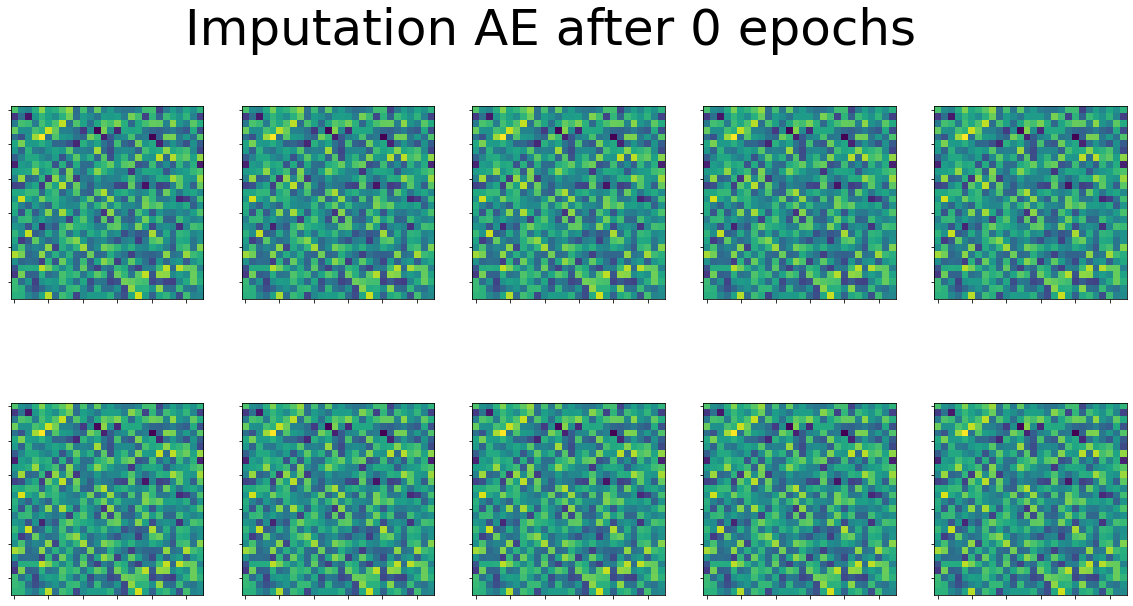

Epoch 100 out of 1000 ==== Loss: 1.8466464281082153


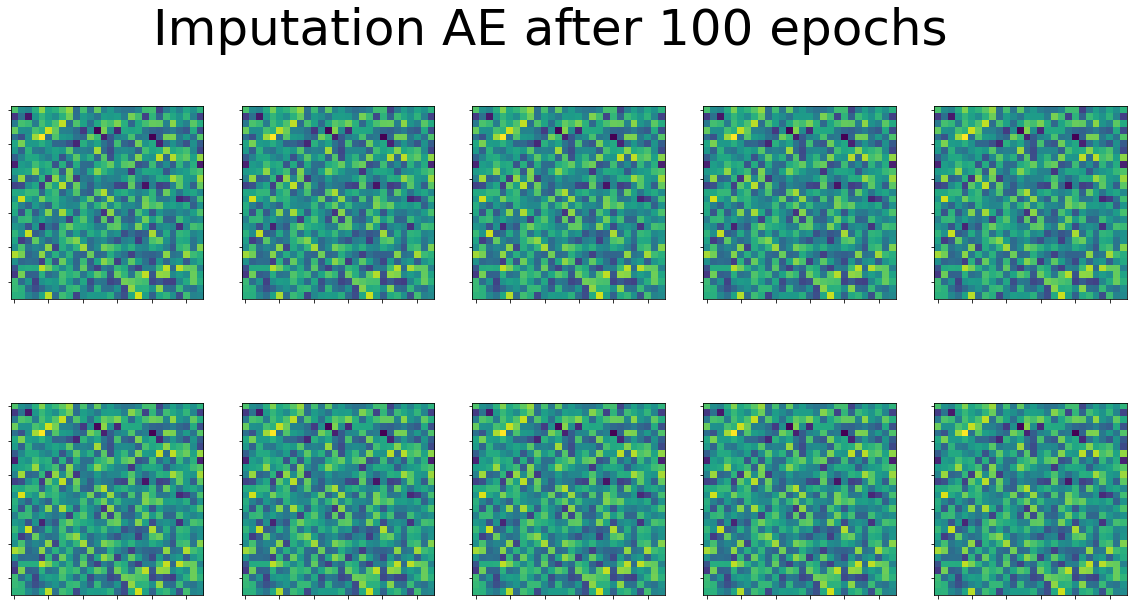

KeyboardInterrupt: 

In [50]:
model.fit(data.data_train)

### You should get something like this at the end:

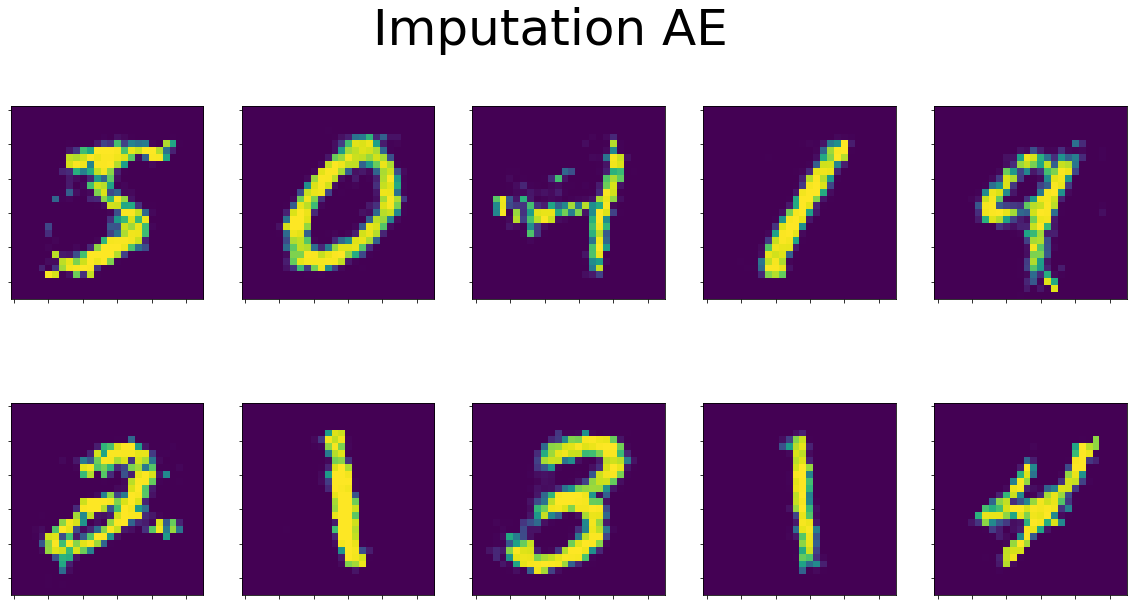

In [ ]:
rec = model.transform(data.data_train)
plot_images(rec[:10], 5, 28, 28, title = "Imputation AE")

In [ ]:
'''***Complute the MSE of the reconstruction using data.true_data and the output of the 3 sklearn methods and your AE***
'''